In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
code_dir = os.path.dirname(os.getcwd())
sys.path.append(code_dir)

import json
import math
from glob import glob
from itertools import permutations
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import IPython.display as ipd

tracks_csv_path = "/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset/extras/fma_info/tracks.csv"
genres_csv_path = "/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset/extras/fma_info/genres.csv"

## Load FMA Annotations

In [2]:
def load_tracks_csv(filepath: str) -> pd.DataFrame:
    import ast
    tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

    COLUMNS = [
        ('track', 'tags'), 
        ('album', 'tags'), 
        ('artist', 'tags'), 
        ('track', 'genres'), 
        ('track', 'genres_all'), 
        ]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [
        ('track', 'date_created'), 
        ('track', 'date_recorded'),
        ('album', 'date_created'), 
        ('album', 'date_released'),
        ('artist', 'date_created'), 
        ('artist', 'active_year_begin'), 
        ('artist', 'active_year_end'), 
        ]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')
    try:
        tracks['set', 'subset'] = tracks['set', 'subset'].astype('category', categories=SUBSETS, ordered=True)
    except (ValueError, TypeError):
        # the categories and ordered arguments were removed in pandas 0.25
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(pd.CategoricalDtype(categories=SUBSETS, ordered=True))

    COLUMNS = [
        ('track', 'genre_top'), 
        ('track', 'license'),
        ('album', 'type'), 
        ('album', 'information'), 
        ('artist', 'bio')
        ]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype('category')

    return tracks

def count_genres(df):
    top_genre_counts = df['track', 'genre_top'].value_counts(dropna=False).to_dict()
    if np.nan in top_genre_counts:
        top_genre_counts["None"] = top_genre_counts.pop(np.nan)
    top_genre_counts = {k: v for k,v in sorted(top_genre_counts.items())}
    return top_genre_counts

In [6]:
df = load_tracks_csv(tracks_csv_path)
print(df.shape)
df.head()

(106574, 52)


album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [7]:
df.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [8]:
drop_cols = [
    ( 'album',          'comments'),
    ( 'album',      'date_created'),
    ( 'album',     'date_released'),
    ( 'album',          'engineer'),
    ( 'album',         'favorites'),
    ( 'album',       'information'),
    ( 'album',           'listens'),
    ( 'album',          'producer'),
    ( 'album',              'tags'), #
    ( 'album',             'title'), #
    ('artist', 'active_year_begin'),
    ('artist',   'active_year_end'),
    ('artist', 'associated_labels'),
    ('artist',               'bio'),
    ('artist',          'comments'),
    ('artist',      'date_created'),
    ('artist',         'favorites'),
    ('artist',          'latitude'),
    ('artist',          'location'),
    ('artist',         'longitude'),
    ('artist',           'members'), #
    ('artist',  'related_projects'),
    ('artist',              'tags'), #
    ('artist',           'website'),
    ('artist',    'wikipedia_page'),
    (   'set',             'split'),
    ( 'track',          'bit_rate'),
    ( 'track',          'comments'),
    ( 'track',          'composer'),
    ( 'track',      'date_created'),
    ( 'track',     'date_recorded'),
    ( 'track',          'duration'),
    ( 'track',         'favorites'),
    ( 'track',       'information'),
    ( 'track',          'interest'),
    ( 'track',     'language_code'),
    ( 'track',           'license'),
    ( 'track',           'listens'),
    ( 'track',          'lyricist'), #
    ( 'track',         'publisher'),
    ( 'track',              'tags'), #
    
]
df.drop(columns=drop_cols, inplace=True)
df.head()

album               artist                 set     track             \
            id tracks   type     id        name  subset genre_top     genres   
track_id                                                                       
2            1      7  Album      1        AWOL   small   Hip-Hop       [21]   
3            1      7  Album      1        AWOL  medium   Hip-Hop       [21]   
5            1      7  Album      1        AWOL   small   Hip-Hop       [21]   
10           6      2  Album      6   Kurt Vile   small       Pop       [10]   
20           4     13  Album      4  Nicky Cook   large       NaN  [76, 103]   

                                                     
                 genres_all number            title  
track_id                                             
2                      [21]      3             Food  
3                      [21]      4     Electric Ave  
5                      [21]      6       This World  
10                     [10]      1          Freeway  
20        [17, 10, 76, 103]      3  Spiritual Level

In [17]:
all_top_genre_counts = count_genres(df)
all_top_genres = sorted([k for k in all_top_genre_counts.keys() if k != "None"])

## Genre CSV

In [14]:
df_genres = pd.read_csv(genres_csv_path, index_col=0)
print(df_genres.shape)
df_genres.head()

(163, 4)


,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [15]:
genre_id_dict = df_genres['title'].to_dict()
genre_id_dict = {v: k for k, v in genre_id_dict.items()}

In [10]:
df['track', 'genre_top_id'] = df.apply(lambda row: genre_id_dict.get(row['track', 'genre_top'], -1), axis=1)

In [11]:
len(df['track', 'genre_top_id'].unique())

17

## Examine Your Splits

In [ ]:
five_fold_dir = "/home/oaraz/nextcore/fingerprinting/datasets/5_fold-fma_full_subset/"

fold_analysis_dir = os.path.join(five_fold_dir, "fold_analysis")
os.makedirs(fold_analysis_dir, exist_ok=True)

In [ ]:
all_top_genre_counts

In [ ]:
for fold_id in range(5):

    fold_dir = os.path.join(five_fold_dir, str(fold_id))

    train_txt = os.path.join(fold_dir, "train.txt")
    test_query_txt = os.path.join(fold_dir, "test_query.txt")
    #test_dummy_txt = os.path.join(fold_dir, "test_dummy.txt")

    # Train Set
    with open(train_txt, "r") as in_f:
        train_paths = [l.strip() for l in in_f.readlines()]
    train_track_ids = [os.path.splitext(os.path.basename(path))[0] for path in train_paths]
    train_top_genres = []
    for track_id in train_track_ids:
        genre = df[df['track_id'] == track_id][('track', 'genre_top')]
        if genre.isna().item():
            genre = "None"
        else:
            genre = genre.item()
        train_top_genres.append(genre)

    # Test Query
    with open(test_query_txt, "r") as in_f:
        test_query_paths = [l.strip() for l in in_f.readlines()]
    test_query_track_ids = [os.path.splitext(os.path.basename(path))[0] for path in test_query_paths]
    test_query_top_genres = []
    for track_id in test_query_track_ids:
        genre = df[df['track_id'] == track_id][('track', 'genre_top')]
        if genre.isna().item():
            genre = "None"
        else:
            genre = genre.item()
        test_query_top_genres.append(genre) 

    # Convert to counter and add missing genres if there are
    train_top_genre_counter = Counter(train_top_genres)
    test_query_top_genre_counter = Counter(test_query_top_genres)
    for genre in all_top_genres:
        if genre not in train_top_genre_counter.keys():
            train_top_genre_counter[genre] = 0
        if genre not in test_query_top_genre_counter.keys():
            test_query_top_genre_counter[genre] = 0

    # Sort by genre
    train_top_genre_counter = {k: v for k,v in sorted(train_top_genre_counter.items())}
    test_query_top_genre_counter = {k: v for k,v in sorted(test_query_top_genre_counter.items())}
    
    fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True,)

    fig.suptitle(f"Top Genre Distribution of Fold{fold_id}")

    ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
    ax[0].set_title("FMA Large")

    ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values())
    ax[1].set_title("Training Set")

    ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
    ax[2].set_title("Test Query Set")

    for _x in ax:
        _x.grid()
        _x.set_ylabel("#Tracks (log)")
        _x.set_xlabel("Genres")
        _x.tick_params(axis='x', labelrotation = 15)
        _x.set_yscale("log")
        _x.set_yticks(10**np.arange(6))

    fig.savefig(os.path.join(fold_analysis_dir, f"{fold_id}.png"))

    plt.close()

In [ ]:
fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True,)

fig.suptitle(f"Top Genre Distribution of Fold{fold_id}")

ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
ax[0].set_title("FMA Large")

ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values())
ax[1].set_title("Training Set")

ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
ax[2].set_title("Test Query Set")

for _x in ax:
    _x.grid()
    _x.set_ylabel("#Tracks (log)")
    _x.set_xlabel("Genres")
    _x.tick_params(axis='x', labelrotation = 15)
    _x.set_yscale("log")
    _x.set_yticks(10**np.arange(6))

plt.show()

## Sample Here

In [19]:
from sklearn.model_selection import train_test_split

### Not stratified

In [29]:
N_TRAIN = 10000
N_VAL = 1000
N_TEST = 5000
N_TOTAL = N_TRAIN + N_VAL + N_TEST

In [31]:
medium_df = df[df['set', 'subset']=="medium"].copy()
train_val_test_df = medium_df.sample(n=N_TOTAL, random_state=27)
print(train_val_test_df.shape)
train_val_test_df.head()

train_val_df, test_query_df = train_test_split(train_val_test_df, test_size=N_TEST, random_state=27)
print(test_query_df.shape)
train_df, val_df = train_test_split(train_val_df, test_size=N_VAL, random_state=27)
print(train_df.shape)
print(val_df.shape)
assert train_df.shape[0] + val_df.shape[0] + test_query_df.shape[0] == N_TOTAL
del train_val_df

train_top_genre_counter = count_genres(train_df)
val_top_genre_counter = count_genres(val_df)
test_query_top_genre_counter = count_genres(test_query_df)

(16000, 12)
(5000, 12)
(10000, 12)
(1000, 12)


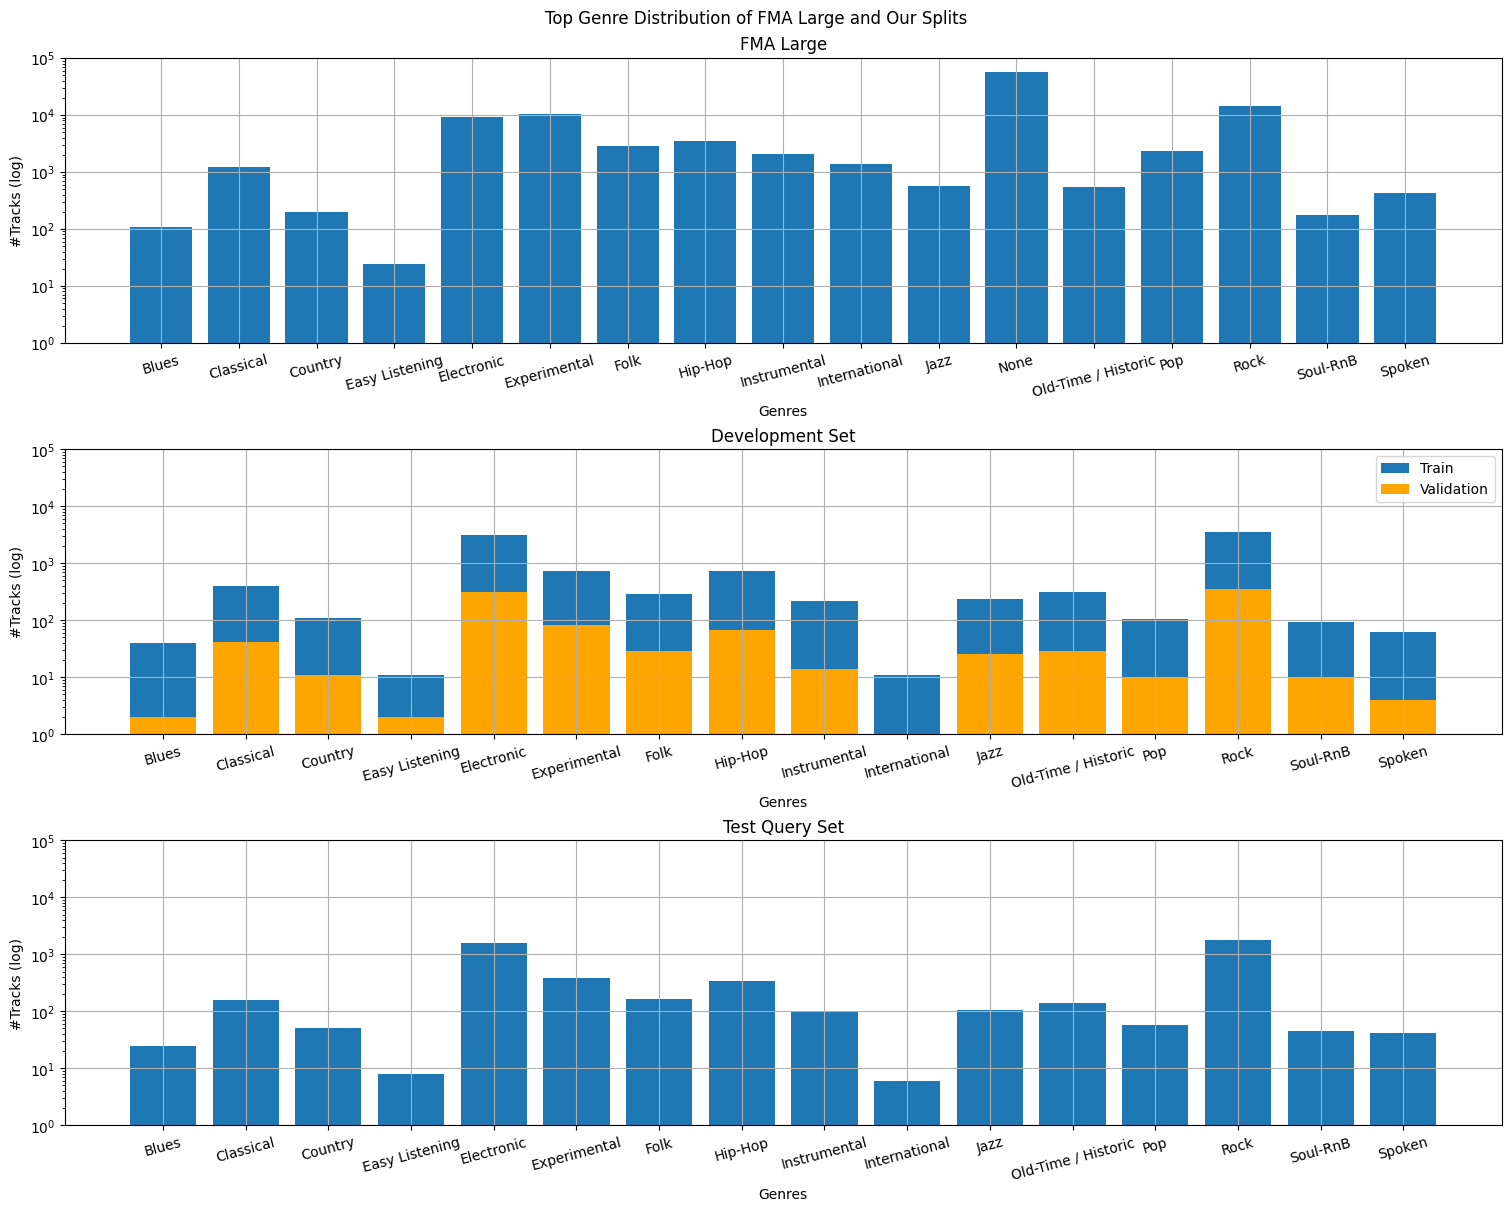

In [33]:
fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True)

ax = np.array(ax).flatten()

fig.suptitle(f"Top Genre Distribution of FMA Large and Our Splits")

ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
ax[0].set_title("FMA Large")

ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values(), label="Train")
ax[1].bar(val_top_genre_counter.keys(), val_top_genre_counter.values(), color="orange", label="Validation")
ax[1].set_title("Development Set")
ax[1].legend()

ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
ax[2].set_title("Test Query Set")

for _x in ax:
    _x.grid()
    _x.set_ylabel("#Tracks (log)")
    _x.set_xlabel("Genres")
    _x.tick_params(axis='x', labelrotation=15)
    _x.set_yscale("log")
    _x.set_yticks(10**np.arange(6))

#fig.savefig(os.path.join('..', f"train_val_test.png"))

plt.show()

### Stratified

In [34]:
medium_df = df[df['set', 'subset']=="medium"].copy()
train_val_df, test_query_df = train_test_split(medium_df, 
                                           train_size=N_TRAIN+N_VAL, 
                                           test_size=N_TEST, 
                                           stratify=medium_df['track', 'genre_top_id'], 
                                           random_state=27)
train_df, val_df = train_test_split(train_val_df, 
                                    train_size=N_TRAIN, 
                                    test_size=N_VAL, 
                                    stratify=train_val_df['track', 'genre_top_id'], 
                                    random_state=27)
assert train_df.shape[0] + val_df.shape[0] + test_query_df.shape[0] == N_TOTAL
del train_val_df

train_top_genre_counter = count_genres(train_df)
val_top_genre_counter = count_genres(val_df)
test_query_top_genre_counter = count_genres(test_query_df)

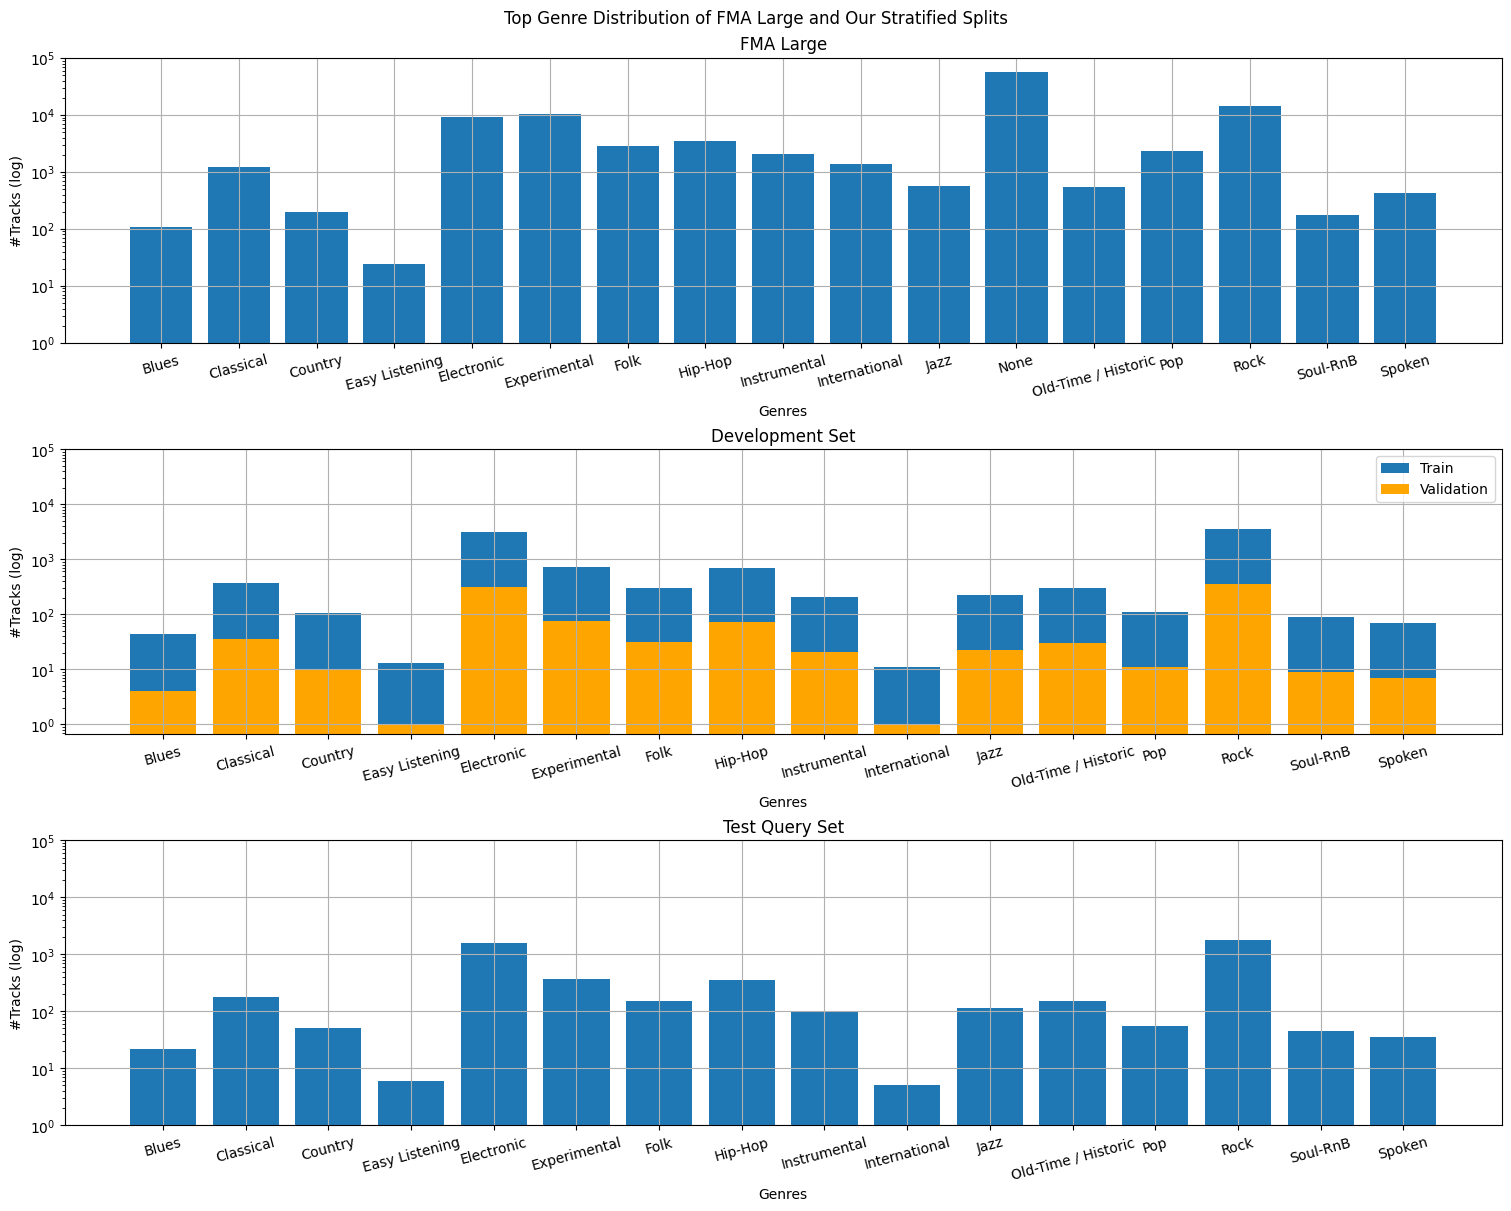

In [41]:
fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True)

fig.suptitle(f"Top Genre Distribution of FMA Large and Our Stratified Splits")

ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
ax[0].set_title("FMA Large")

ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values(), label="Train")
ax[1].bar(val_top_genre_counter.keys(), val_top_genre_counter.values(), color="orange", label="Validation")
ax[1].set_title("Development Set")
ax[1].legend()

ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
ax[2].set_title("Test Query Set")

for _x in ax:
    _x.grid()
    _x.set_ylabel("#Tracks (log)")
    _x.set_xlabel("Genres")
    _x.tick_params(axis='x', labelrotation=15)
    _x.set_yscale("log")
    _x.set_yticks(10**np.arange(6))

fig.savefig(os.path.join('..', f"train_val_test-stratified.png"))

plt.show()

## Examine the NAFP Splits

In [42]:
import glob
import os
from itertools import combinations
import random

In [45]:
music_dir = "/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset/music"

train_dir = os.path.join(music_dir, "train-10k-30s")
val_dir = os.path.join(music_dir, "val-query-db-500-30s")
test_dummy_dir = os.path.join(music_dir, "test-dummy-db-100k-full/fma_full")
test_query_db_dir = os.path.join(music_dir, "test-query-db-500-30s/db")

train_fps = sorted(glob.glob(os.path.join(train_dir, "**/*.wav"), recursive=True))
val_fps = sorted(glob.glob(os.path.join(val_dir, "**/*.wav"), recursive=True))
test_dummy_fps = sorted(glob.glob(os.path.join(test_dummy_dir, "**/*.wav"), recursive=True))
test_query_db_fps = sorted(glob.glob(os.path.join(test_query_db_dir, "**/*.wav"), recursive=True))

train_fnames = set([os.path.basename(fp) for fp in train_fps])
print(len(train_fnames))
val_fnames = set([os.path.basename(fp) for fp in val_fps])
print(len(val_fnames))
test_dummy_fnames = set([os.path.basename(fp) for fp in test_dummy_fps])
print(len(test_dummy_fnames))
test_query_db_fnames = set([os.path.basename(fp) for fp in test_query_db_fps])
print(len(test_query_db_fnames))

10000
500
93458
500


In [46]:
required = 100000 - len(test_dummy_fnames)
print(required)

6542


In [47]:
for a,b in combinations([('train', train_fnames), ('val', val_fnames), ('test_dummy', test_dummy_fnames), ('test_query', test_query_db_fnames)], 2):
    print(a[0], b[0], len(a[1].intersection(b[1])))

train val 0
train test_dummy 0
train test_query 0
val test_dummy 0
val test_query 0
test_dummy test_query 0


In [77]:
train_track_ids = [int(os.path.splitext(os.path.basename(fp))[0].lstrip('0')) for fp in train_fps]
val_track_ids = [int(os.path.splitext(os.path.basename(fp))[0]) for fp in val_fps]
test_query_db_track_ids = [int(os.path.splitext(os.path.basename(fp))[0]) for fp in test_query_db_fps]

train_df = df.loc[train_track_ids].copy()
val_df = df.loc[val_track_ids].copy()
test_query_db_df = df.loc[test_query_db_track_ids].copy()

train_top_genre_counter = count_genres(train_df)
val_top_genre_counter = count_genres(val_df)
test_query_top_genre_counter = count_genres(test_query_df)

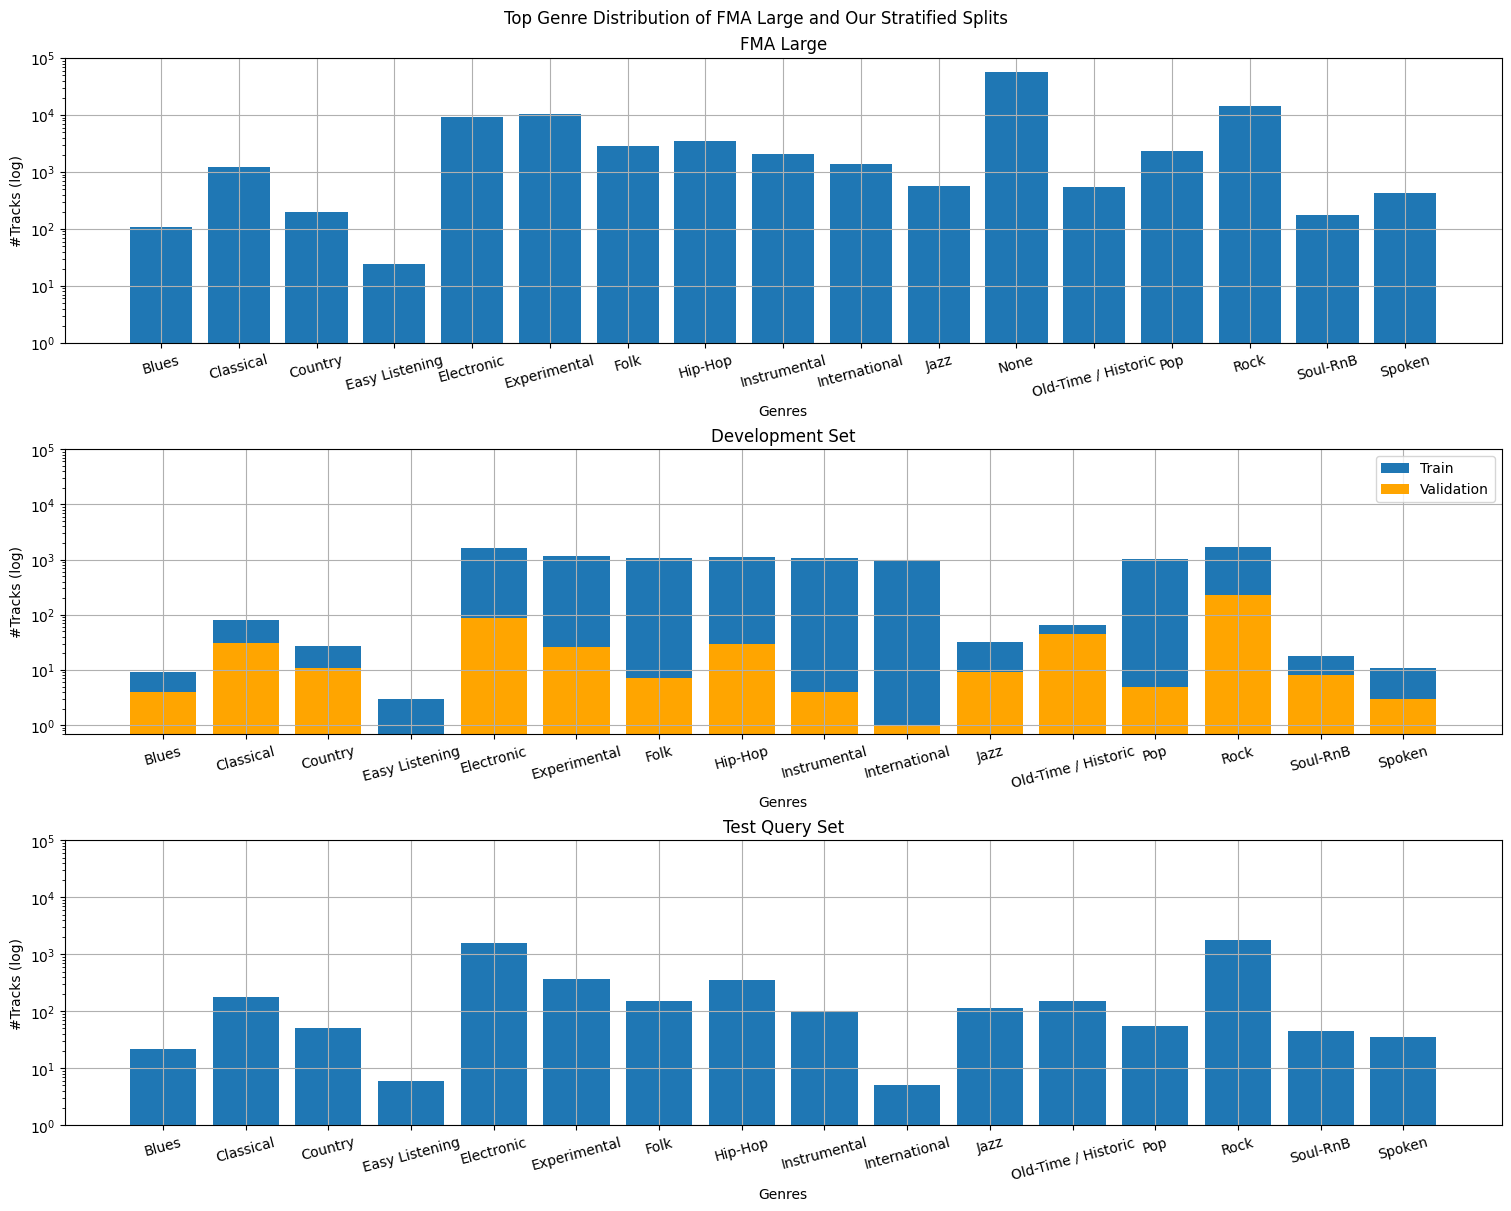

In [78]:
fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True)

fig.suptitle(f"Top Genre Distribution of FMA Large and Our Stratified Splits")

ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
ax[0].set_title("FMA Large")

ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values(), label="Train")
ax[1].bar(val_top_genre_counter.keys(), val_top_genre_counter.values(), color="orange", label="Validation")
ax[1].set_title("Development Set")
ax[1].legend()

ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
ax[2].set_title("Test Query Set")

for _x in ax:
    _x.grid()
    _x.set_ylabel("#Tracks (log)")
    _x.set_xlabel("Genres")
    _x.tick_params(axis='x', labelrotation=15)
    _x.set_yscale("log")
    _x.set_yticks(10**np.arange(6))

fig.savefig(os.path.join('..', f"train_val_test-nafp.png"))

plt.show()

### Find Missing tracks

In [ ]:
train_val = train_fnames.union(val_fnames)
print(len(train_val))

missing_ids = random.sample(list(train_val), k=required)
print(len(missing_ids))
print(len(set(missing_ids).intersection(test_dummy_fnames)))

print(len(set(missing_ids).intersection(test_query_db_fnames)))

with open("/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset-missing_6542/missing_ids.txt", "w") as o_f:
    o_f.write("\n".join(missing_ids))

for fnames in [train_fnames, val_fnames, test_dummy_fnames, test_query_db_fnames]:
    for fname in fnames:
        fname = os.path.splitext(fname)[0]
        if df[df['track_id']==int(fname)].size==0:
            print("wtf")

#### Move files

In [ ]:
with open("/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset-missing_6542/missing_ids.txt", "r") as i_f:
    missing_ids = [id.strip() for id in i_f.readlines()]
for id in missing_ids:
    if id == "":
        print("wtf")

In [ ]:
missing_ids[:10]

In [ ]:
with open("/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset-missing_6542/missing_ids-source_paths.txt", "w") as o_f:
    for id in missing_ids:
        id = os.path.splitext(id)[0]
        source_path = os.path.join(id[:3], f"{id}.mp3") # "/mnt/mtgdb-audio/incoming/fma/audio"
        o_f.write(f"{source_path}\n")

In [ ]:
source_path

## test_ids

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
test_ids_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/eval/test_ids_icassp2021.npy"
test_ids = np.load(test_ids_path)

In [ ]:
boundaries_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/logs/emb/640_lamb/101/db-track_boundaries.npy"
boundaries = np.load(boundaries_path)

In [ ]:
counter = {n: 0 for n in range(500)}
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    counter[track_idx] += 1

In [ ]:
sum([1 if c==0 else 0 for c in counter.values()])

In [ ]:
np.median(list(counter.values()))

In [ ]:
max(counter.values())

In [ ]:
x = list(counter.keys())
y = list(counter.values())
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y)
ax.grid()
plt.show()

In [ ]:
test_seq_len = [1, 3, 5, 9, 15, 19]

test_ids = []
for s,e in boundaries:
    # Cut the query into segments of test_seq_len
    # If the last segment is shorter than test_seq_len, ignore it
    test_ids.append(np.arange(s, e+1-test_seq_len[-1], 11)) # end is inclusive
test_ids = np.concatenate(test_ids)
print(len(test_ids))

counter = {n: 0 for n in range(500)}
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    counter[track_idx] += 1
print(sum([1 if c==0 else 0 for c in counter.values()]))

x = list(counter.keys())
y = list(counter.values())
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y)
ax.grid()
plt.show()

In [ ]:
test_seq_len = [1, 3, 5, 9, 15, 19]

test_ids = []
for s,e in boundaries:
    # Cut the query into segments of test_seq_len
    # If the last segment is shorter than test_seq_len, ignore it
    test_ids.append(np.arange(s, e+1-test_seq_len[-1], 5)) # end is inclusive
test_ids = np.concatenate(test_ids)

print(len(test_ids))

counter = {n: 0 for n in range(500)}
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    counter[track_idx] += 1

x = list(counter.keys())
y = list(counter.values())
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y)
ax.grid()
plt.show()

### Check if boundaries are preserved

In [ ]:
test_ids_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/eval/test_ids_icassp2021.npy"
test_ids = np.load(test_ids_path)

boundaries_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/logs/emb/640_lamb/101/db-track_boundaries.npy"
boundaries = np.load(boundaries_path)

In [ ]:
test_seq_len = [1, 3, 5, 9, 15, 19]

In [ ]:
counter = 0
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    _, u_b = boundaries[track_idx]
    for s_l in test_seq_len:
        if test_id + s_l - 1 <= u_b:
            continue
        else:
            #print(test_id, s_l, u_b)
            counter += 1
print(100*counter/(len(test_seq_len)*len(test_ids)))